# Knowledge Distillation with Vision Tranformers!

We are going to learn about Knowledge Distillation, the method behind [distilGPT](https://huggingface.co/distilgpt2) and [distilbert](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english), two of *the most downloaded models on the Huggingface Hub!*

Presumably, we've all had teachers who "teach" by simply providing us the correct answers and then test us on questions we haven't seen before, analogous to Supervised Training of machine learning models where we provide a labelled dataset to train on. Instead of having a model train on labels, however, we can pursue [Knowledge Distillation](https://arxiv.org/abs/1503.02531) as an alternative to arrive at a much smaller model that can perform comparably to the larger model, and much faster to boot.

## For some intuition, 

Imagine you were given this multiple choice question:

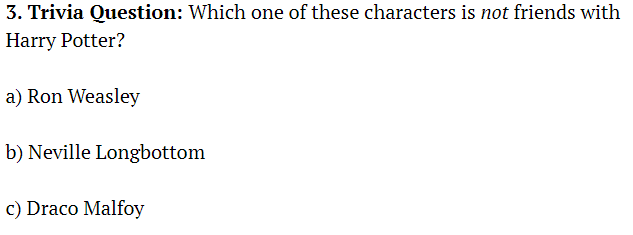

If you had someone just tell you "the answer is Dracoy Malfoy", that doesn't teach you a whole lot about each of the characters' relative relationships with Harry Potter.

On the other hand, if someone tells you "I am very confident it is not Ron Weasley, I am somewhat confident it is not Neville Longbottom, and I am very confident that it *is* Draco Malfoy", this gives you some information about each of these characters' relationships to Harry Potter! This is precisely the kind of information that gets passed down to our student model under the Knowledge Distillation paradigm.

We'll begin by importing the required libraries:

In [11]:
from datasets import load_dataset, DatasetDict
from transformers import AutoImageProcessor, AutoModelForImageClassification, ViTConfig, ViTForImageClassification
from transformers import ViTImageProcessor, ViTConfig, ViTForImageClassification
from transformers import TrainingArguments, Trainer
import evaluate

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt 

We will be distilling the knowledge from ```asusevski/vit-base-patch16-224-oxford-pets```, a fine-tuned model based on ```google/vit-base-patch16-224``` into a randomized ```WinKawaks/vit-tiny-patch16-224``` model.

We'll do this based on ```oxford-pets dataset```, a dataset with *37 classes of dogs and cats*. The fine-tuned ViT model that will be our teacher model was trained on this dataset, achieving about **93%** accuracy!

First, lets see the teacher in action:

In [4]:
dataset = load_dataset("pcuenq/oxford-pets")

In [5]:
id2label = {int_label: str_label for int_label, str_label in enumerate(sorted(list(set(dataset['train']['label']))))}
label2id = {str_label: int_label for int_label, str_label in enumerate(sorted(list(set(dataset['train']['label']))))}

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_model_name = "asusevski/vit-base-patch16-224-oxford-pets"
teacher_model = AutoModelForImageClassification.from_pretrained(teacher_model_name).to(device)
teacher_model.eval()
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
accuracy = evaluate.load("accuracy")

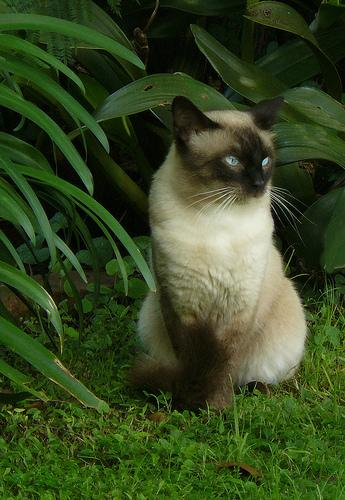

In [7]:
dataset["train"][0]['image']

In [8]:
inputs = processor(dataset["train"][0]["image"], return_tensors="pt") # Here, using default processor on the image
inputs = {key: value.to(device) for key, value in inputs.items()} # Converting to a dictionary
model_logits = teacher_model(**inputs).logits
model_prediction = torch.argmax(model_logits, dim=1).item()
print(id2label[model_prediction])

Siamese


The model was able to infer that this was a Siamese cat, and a stunning one at that.

This is a great time to dive into *how* we will be using the teacher model's prior knowedge to teach a student model with knowledge distillation.

What we're doing when we perform Knowledge Distillation is, for a given image, trying to get the student model's distribution to mimic that of the Teacher's distribution over all the classes.

Some of the key terms you will encounter are:
- ```temperature```
- ```KL Divergence```
- ```lambda parameter```

Lets start by explaining ```temperature```.

**Temperature** is a hyperparameter that controls the importance of each soft target. Soft target is a term for the teachers' distribution over the output classes, since they are precisely what our student wants to *approach*. A larger temperature will result in a higher loss, thus penalizing the student model further.

Lets look at the teacher's distribution over the classes and then modify the distribution with 2 examples:
- a "low" temperature of 2
- a "high" temperature of 8.

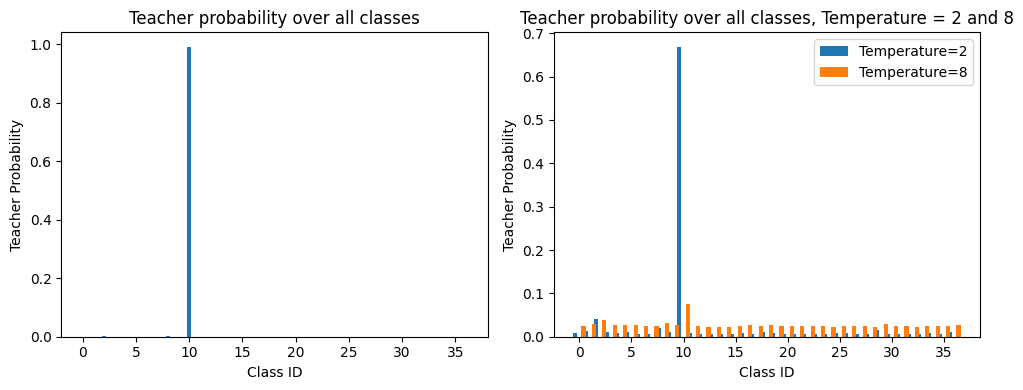

In [42]:
temperature_no_change = 1
low_temperature = 2
high_temperature = 8

teacher_distribution = F.softmax(model_logits / temperature_no_change, dim=-1).cpu().detach().numpy().reshape(-1)
teacher_distribution_low_temp = F.softmax(model_logits / low_temperature, dim=-1).cpu().detach().numpy().reshape(-1)
teacher_distribution_high_temp = F.softmax(model_logits / high_temperature, dim=-1).cpu().detach().numpy().reshape(-1)


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].bar(id2label.keys(), teacher_distribution, width = 0.4)
axs[0].set_title("Teacher probability over all classes")
axs[0].set_ylabel('Teacher Probability')
axs[0].set_xlabel("Class ID")

axs[1].bar(np.fromiter(id2label.keys(), dtype=float) - 0.4, teacher_distribution_low_temp, width = 0.4, label='Temperature=2')
axs[1].bar(np.fromiter(id2label.keys(), dtype=float) + 0.4, teacher_distribution_high_temp, width = 0.4, label='Temperature=8')
axs[1].set_title("Teacher probability over all classes, Temperature = 2 and 8")
axs[1].set_ylabel('Teacher Probability')
axs[1].set_xlabel("Class ID")
axs[1].legend()
plt.tight_layout()
plt.show()

As we can see, a higher temperature sort of smoothes out the distribution, making the probabilities easier to learn from.

Next, we have ```KL Divergence```.

**KL Divergence** is a measure of how similar/dissimilar two probability distributions are. It quantifies how much information is lost when one distribution (our student) is used to approximate the other. If it is 0, then in the case of knowledge distillation, that would mean the student has nothing left to learn from the teacher.

Finally, we have the ```lambda parameter```.

**Lambda parameter** is a weight applied to the overall loss functions terms. There are two terms -- the distillation loss (which comes from the KL-Divergence, as discussed above), and the students' own loss on the dataset. We take a linear combination of these terms, weighted by lambda, and that is our overall loss.

Now we have to prepare the data for ingestion by the HuggingFace Trainer. We prepared the inputs by using the ```ViTImageProcessor``` class above, but we also need to preprare the labels for training. These transformes will be written in the function ```transformers``` and we can then use the ```with_transform``` method so that these transforms will be applied whenever a batch is sampled from the dataset.

*Note* -- we could use ```dataset.map``` to achieve a similar result, but this can be time-consuming

In [105]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor([x for x in batch['image']],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

In [106]:
dataset = dataset.with_transform(transforms)

In [108]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

Splitting the dataset into train, validation, and test sets:

In [ ]:
train_test_dataset = dataset['train'].train_test_split(test_size=0.2)
train_val_dataset = train_test_dataset['train'].train_test_split(test_size=(0.1/0.8))
train_test_valid_dataset = DatasetDict({
    'train': train_val_dataset['train'],
    'valid': train_val_dataset['test'],
    'test': train_test_dataset['test']
})

First, as a baseline model, we'll fine-tune ```WinKawaks/vit-tiny-patch16-224``` for 5 epochs on the same training data to get an idea of what the performance would look like!

For this, we'll rely on HuggingFace's Trainer API. We need
1. Our base model
2. ```Training Arguments```
3. A compute_metrics function
4. Our final ```Trainer``` object

Initializing a randomized ```WinKawaks/vit-tiny-patch16-224``` model here, we only need to pass a ```ViTConfig``` object to the ```ViTForImageClassification``` class. We'll also modify the config for our specific use-case by adding the number of labels required (so the classifier head is appropriately configued) and the mappings from ids to labels.

In [137]:
config = ViTForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224").config
config.id2label = id2label
config.label2id = label2id
config.num_labels=len(id2label)
base_model = ViTForImageClassification(config).to(device)

Next, we'll configure our arguments. Here is where we will also push our fine-tuned model to the HuggingFace Hub (we have to log in first)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [138]:
training_args = TrainingArguments(
    output_dir="fine-tuned-vit",
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    push_to_hub=True,
    load_best_model_at_end=True,
)

Defining our compute metrics function -- we'll leave it at just accuracy for the purposes of this demo, but you can add others if you so choose. We'll re-use this later for when we train a model through Knowledge Distillation.

In [139]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy.compute(references=labels, predictions=np.argmax(predictions, axis=1))
    return {"accuracy": acc["accuracy"]}

And finally our ```Trainer``` object!

In [140]:
trainer = Trainer(
    model=base_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["test"],
    tokenizer=processor
)

Now for the most satisfying part of any HuggingFace Project -- calling ```trainer.train()```

In [141]:
trainer.train()

Trainer is attempting to log a value of "{0: 'Abyssinian', 1: 'Bengal', 2: 'Birman', 3: 'Bombay', 4: 'British Shorthair', 5: 'Egyptian Mau', 6: 'Maine Coon', 7: 'Persian', 8: 'Ragdoll', 9: 'Russian Blue', 10: 'Siamese', 11: 'Sphynx', 12: 'american bulldog', 13: 'american pit bull terrier', 14: 'basset hound', 15: 'beagle', 16: 'boxer', 17: 'chihuahua', 18: 'english cocker spaniel', 19: 'english setter', 20: 'german shorthaired', 21: 'great pyrenees', 22: 'havanese', 23: 'japanese chin', 24: 'keeshond', 25: 'leonberger', 26: 'miniature pinscher', 27: 'newfoundland', 28: 'pomeranian', 29: 'pug', 30: 'saint bernard', 31: 'samoyed', 32: 'scottish terrier', 33: 'shiba inu', 34: 'staffordshire bull terrier', 35: 'wheaten terrier', 36: 'yorkshire terrier'}" for key "id2label" as a parameter. MLflow's log_param() only accepts values no longer than 250 characters so we dropped this attribute. You can use `MLFLOW_FLATTEN_PARAMS` environment variable to flatten the parameters and avoid this messa

Epoch,Training Loss,Validation Loss,Accuracy
1,3.607100,3.596430,0.037212
2,3.604100,3.585197,0.037212
3,3.540300,3.514590,0.058187
4,3.500300,3.465261,0.071042
5,3.433900,3.433190,0.077131


TrainOutput(global_step=1080, training_loss=3.5377999482331455, metrics={'train_runtime': 518.8139, 'train_samples_per_second': 49.854, 'train_steps_per_second': 2.082, 'total_flos': 1.2921960717517824e+17, 'train_loss': 3.5377999482331455, 'epoch': 5.0})

In [142]:
trainer.evaluate(train_test_valid_dataset["test"])

{'eval_loss': 3.43319034576416,
 'eval_accuracy': 0.07713125845737483,
 'eval_runtime': 19.4973,
 'eval_samples_per_second': 75.805,
 'eval_steps_per_second': 3.18,
 'epoch': 5.0}

With just training a randomly initialized ViT on the dataset for 5 epochs, the model reaches around 7.7% accuracy. Note that since there are 37 classes, this is a vast improvement over a dummy classifier that picks at random, which we would expect to achieve around 2.7% accuracy.

Now, lets initialize another ViT from scratch and train **with Knowledge Distillation**:

In [143]:
config = ViTForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224").config
config.id2label = id2label
config.label2id = label2id
config.num_labels=len(id2label)
student_model = ViTForImageClassification(config).to(device)

The main modification we will make here is that we're calling a modified ```ImageDistilTrainer``` that inherits from the parent ```Trainer``` class. We need to *overwrite* the loss function so that its representative of the distillation loss function we discussed previously.

Recall, the final loss is a weighted average of the standard cross-entropy loss and the distillation loss, weighted by ```lambda_param```.

In [144]:
class ImageDistilTrainer(Trainer):
    def __init__(self, teacher_model=None, student_model=None, temperature=None, lambda_param=None,  *args, **kwargs):
        super().__init__(model=student_model, *args, **kwargs)
        self.teacher = teacher_model
        self.student = student_model
        self.loss_function = nn.KLDivLoss(reduction="batchmean")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.teacher.to(device)
        self.teacher.eval()
        self.temperature = temperature
        self.lambda_param = lambda_param

    def compute_loss(self, student, inputs, return_outputs=False):
        pixel_values = inputs["pixel_values"]
        labels = inputs["labels"]
        student_output = self.student(**inputs)

        with torch.no_grad():
            teacher_output = self.teacher(**inputs)

        # Compute soft targets for teacher and student
        soft_teacher = F.softmax(teacher_output.logits / self.temperature, dim=-1)
        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)

        # Compute the loss
        distillation_loss = self.loss_function(soft_student, soft_teacher) * (self.temperature ** 2)

        # Compute the true label loss
        student_target_loss = student_output.loss

        # Calculate final loss
        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss
        return (loss, student_output) if return_outputs else loss

The rest is largely the same; initialize our ```TrainingArguments``` and our ```ImageDistilTrainer``` instead of the ```Trainer``` object.

In [145]:
training_args = TrainingArguments(
    output_dir="vit-tiny-kd-pets",
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    push_to_hub=True,
    load_best_model_at_end=True,
)

We'll train with ```lambda_param=0.5``` and ```temperature=5```. Note that the authors Hinton et. al found that it was best to use a value of ```lambda_param``` that would place greater weight on the distillation loss, but for our purposes we'll proceed by weighting these loss functions equally.

In [146]:
teacher_model.eval()
trainer = ImageDistilTrainer(
    student_model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["test"],
    tokenizer=processor,
    temperature=5,
    lambda_param=0.5
)

Train!!!

In [147]:
trainer.train()

Trainer is attempting to log a value of "{0: 'Abyssinian', 1: 'Bengal', 2: 'Birman', 3: 'Bombay', 4: 'British Shorthair', 5: 'Egyptian Mau', 6: 'Maine Coon', 7: 'Persian', 8: 'Ragdoll', 9: 'Russian Blue', 10: 'Siamese', 11: 'Sphynx', 12: 'american bulldog', 13: 'american pit bull terrier', 14: 'basset hound', 15: 'beagle', 16: 'boxer', 17: 'chihuahua', 18: 'english cocker spaniel', 19: 'english setter', 20: 'german shorthaired', 21: 'great pyrenees', 22: 'havanese', 23: 'japanese chin', 24: 'keeshond', 25: 'leonberger', 26: 'miniature pinscher', 27: 'newfoundland', 28: 'pomeranian', 29: 'pug', 30: 'saint bernard', 31: 'samoyed', 32: 'scottish terrier', 33: 'shiba inu', 34: 'staffordshire bull terrier', 35: 'wheaten terrier', 36: 'yorkshire terrier'}" for key "id2label" as a parameter. MLflow's log_param() only accepts values no longer than 250 characters so we dropped this attribute. You can use `MLFLOW_FLATTEN_PARAMS` environment variable to flatten the parameters and avoid this messa

Epoch,Training Loss,Validation Loss,Accuracy
1,3.692700,3.686777,0.034506
2,3.653800,3.621709,0.054804
3,3.621400,3.575505,0.075101
4,3.547700,3.524772,0.083897
5,3.498200,3.507506,0.090663


TrainOutput(global_step=1080, training_loss=3.6046550892017506, metrics={'train_runtime': 876.2687, 'train_samples_per_second': 29.517, 'train_steps_per_second': 1.232, 'total_flos': 1.2921960717517824e+17, 'train_loss': 3.6046550892017506, 'epoch': 5.0})

In [148]:
trainer.evaluate(train_test_valid_dataset["test"])

{'eval_loss': 3.5075058937072754,
 'eval_accuracy': 0.09066305818673884,
 'eval_runtime': 33.1969,
 'eval_samples_per_second': 44.522,
 'eval_steps_per_second': 1.868,
 'epoch': 5.0}

Hooray! Our little student model has learned so much in such a short period of time. It outperforms the baseline performance of just training on the data with a standard loss function!